In [1]:
import sys

sys.path.append("/home/maximilien/work/pixano/")
sys.path.append("/home/maximilien/work/lib/bop_toolkit")

dir = "/home/maximilien/work/pixano/pixano/data/bop"

In [2]:
import lance
import duckdb

import bop_toolkit_lib.dataset.bop_webdataset as btk

import webdataset as wds

import json
import numpy as np
import time
from pathlib import Path
from PIL import Image as pilImage
import pyarrow as pa

from pixano.core import *
from pixano.data import data_loader
from pixano.core.arrow_types import *
from pixano.transforms import image_to_binary


In [3]:

from lance import LanceDataset
from pixano.core.dataset import DatasetInfo


class BOPImporter(data_loader.DataLoader):

    def __init__(
        self,
        shard_list:list[str],
        info:DatasetInfo,
        target_dir: Path,
    ):
        
        self._wds_pipeline = wds.DataPipeline(
            wds.SimpleShardList(shard_list),
            wds.tarfile_to_samples()
        )
        self.info = info
        self.target_dir = target_dir

    @property
    def features(self) -> Features:
        return Features.from_string_dict(self.info.features)

    def create_json(self):
        """Create dataset spec.json"""

        # Read dataset
        #"dataset = ds.dataset(self.target_dir + "/db", partitioning=self.partitioning)

        # Check number of rows in the created dataset
        #self.info.num_elements = dataset.count_rows()

        # Create spec.json
        with open(self.target_dir + "/spec.json", "w") as f:
            json.dump(vars(self.info), f, indent=4)


    def fields(self):
        return self.features.to_fields()
    
    def schema(self):
        return pa.schema(self.fields())
    
    def get_row(self, split: str):
        for n, row in enumerate(self._wds_pipeline):
            if True:
                sample = btk.decode_sample(
                    row,
                    decode_camera=True,
                    decode_rgb=True,
                    decode_gray=False,
                    decode_depth=True,
                    decode_gt=True,
                    decode_gt_info=True,
                    decode_mask_visib=True,
                    decode_mask=True,
                )

                id = row["__key__"]

                im_pil = pilImage.fromarray(sample['im_rgb'])
                im_pil.thumbnail((128, 128))
                preview = image_to_binary(im_pil)

                rgb = Image(f"media/rgb/{id}.jpeg", image_to_binary(im_pil, format="JPEG"), preview)
                rgbs = ImageType.Array.from_list([rgb])

                depths = DepthImageType.Array.from_list([DepthImage(depth_map=sample["im_depth"], shape=sample["im_depth"].shape)])

                cameras = CameraType.Array.from_list([Camera.from_dict(sample['camera'])])

                nb_object = len(sample['gt'])

                objects_id = [sample['gt'][i]['obj_id'] for i in range(nb_object)]
                gt = [Pose(sample['gt'][i]['cam_R_m2c'].flatten(), sample['gt'][i]['cam_t_m2c'].flatten()) for i in range(nb_object)]

                gt_infos = [
                    GtInfo.from_dict(
                        {
                            **sample["gt_info"][i],
                            "bbox_obj": BBox.from_xywh(sample["gt_info"][i]["bbox_obj"]),
                            "bbox_visib": BBox.from_xywh(sample["gt_info"][i]["bbox_visib"]),
                        }
                    )
                    for i in range(nb_object)
                ]

                masks = [CompressedRLE.from_mask(sample['mask'][i]) for i in range(nb_object)]
                masks_visib = [CompressedRLE.from_mask(sample['mask_visib'][i]) for i in range(nb_object)]

                objects_id_arr = pa.array([objects_id])
                gt_arr = PoseType.Array.from_lists([gt])
                gt_infos_arr = GtInfoType.Array.from_lists([gt_infos])
                masks_arr = CompressedRLEType.Array.from_lists([masks])
                masks_visib_arr = CompressedRLEType.Array.from_lists([masks_visib])

                struct_arr = pa.StructArray.from_arrays(
                    [
                        pa.array([id]),
                        rgbs,
                        depths,
                        cameras,
                        objects_id_arr,
                        masks_arr,
                        masks_visib_arr,
                        gt_arr,
                        gt_infos_arr,
                        pa.array([split])
                    ],
                    fields=self.fields()
                )

                yield pa.RecordBatch.from_struct_array(struct_arr)


    def import_dataset(self, max_rows_per_file: int = 2048) -> LanceDataset:
        """Import dataset to Pixano format

        Args:
            batch_size (int, optional): Number of rows per file. Defaults to 2048.
        """
                # Save to file


        reader = pa.RecordBatchReader.from_batches(self.schema(), self.get_row("train", ))
        ds = lance.write_dataset(reader, self.target_dir ,max_rows_per_file=max_rows_per_file)

        self.info.num_elements = ds.count_rows()

        # Create spec.json
        self.create_json()
        
        return ds


In [4]:
shard_list = ["/home/maximilien/work/bop_data/shard-000000.tar"]




In [5]:
features_dict = {
    'id': 'str',
    'rgb': 'Image',
    'depth': 'DepthImage',
    'camera': 'Camera',
    'objects_id': '[int]',
    'masks': '[CompressedRLE]',
    'masks_visib': '[CompressedRLE]',
    'gt': '[Pose]',
    'gt_info':'[GtInfo]',
    'split':'str'
}

bop_info = DatasetInfo(id="0", name="Bop", description="Bop dataset", features=features_dict)

bop_importer = BOPImporter(shard_list, bop_info, dir + '/bop_ds.lance')

bop_ds = bop_importer.import_dataset()

/home/maximilien/miniconda3/envs/pixano/lib/python3.11/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [6]:
bop_ds.head(3)

pyarrow.Table
id: string
rgb: struct<uri: string, bytes: binary, preview_bytes: binary>
  child 0, uri: string
  child 1, bytes: binary
  child 2, preview_bytes: binary
depth: struct<bytes: binary, shape: fixed_size_list<item: int32>[2]>
  child 0, bytes: binary
  child 1, shape: fixed_size_list<item: int32>[2]
      child 0, item: int32
camera: struct<cam_K: list<item: double>, cam_R_w2c: list<item: double>, cam_t_w2c: list<item: double>, depth_scale: double>
  child 0, cam_K: list<item: double>
      child 0, item: double
  child 1, cam_R_w2c: list<item: double>
      child 0, item: double
  child 2, cam_t_w2c: list<item: double>
      child 0, item: double
  child 3, depth_scale: double
objects_id: list<item: int64>
  child 0, item: int64
masks: list<item: struct<size: fixed_size_list<item: int32>[2], counts: binary>>
  child 0, item: struct<size: fixed_size_list<item: int32>[2], counts: binary>
      child 0, size: fixed_size_list<item: int32>[2]
          child 0, item: int32
    

In [7]:
r = bop_ds.take([0]).to_pylist()[0]
r['rgb'] = Image.from_dict(r['rgb'])
r['rgb'].display()

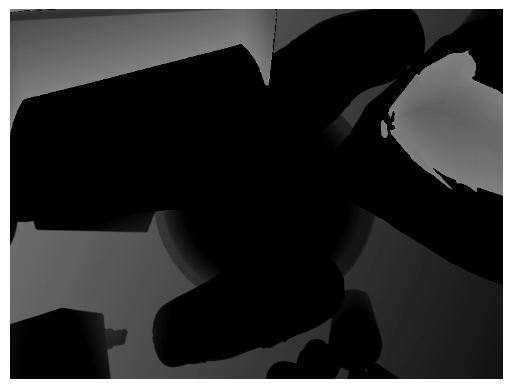

<Figure size 54000x72000 with 0 Axes>

In [8]:
dim:DepthImage = DepthImage.from_dict(r['depth'])
dim.display()

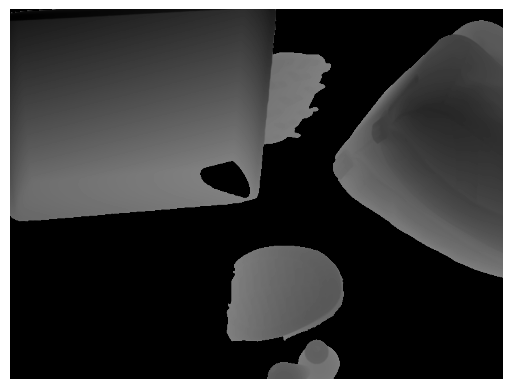

<Figure size 54000x72000 with 0 Axes>

In [9]:
dim.to_gray_levels().display()

In [10]:
r['rgb'].display()

In [11]:
duckdb.query("SELECT * FROM bop_ds LIMIT 10").to_df()


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

id                                                rgb  \
0  022722_000018  {'uri': 'media/rgb/022722_000018.jpeg', 'bytes...   
1  022833_000014  {'uri': 'media/rgb/022833_000014.jpeg', 'bytes...   
2  015599_000028  {'uri': 'media/rgb/015599_000028.jpeg', 'bytes...   
3  021477_000029  {'uri': 'media/rgb/021477_000029.jpeg', 'bytes...   
4  002826_000020  {'uri': 'media/rgb/002826_000020.jpeg', 'bytes...   
5  020955_000004  {'uri': 'media/rgb/020955_000004.jpeg', 'bytes...   
6  005430_000017  {'uri': 'media/rgb/005430_000017.jpeg', 'bytes...   
7  022143_000031  {'uri': 'media/rgb/022143_000031.jpeg', 'bytes...   
8  022150_000005  {'uri': 'media/rgb/022150_000005.jpeg', 'bytes...   
9  015065_000016  {'uri': 'media/rgb/015065_000016.jpeg', 'bytes...   

                                               depth  \
0  {'bytes': b'\xcd\x9c\x8fD\x9a\x99\x8fD3\x93\x8...   
1  {'bytes': b'\x00`\x14D\x00\x80\x14D\x9a\x99\x1...   
2  {'bytes': b'\xcd\xa4cE\x00\x98cE3\x8bcEg~cE\x9...   
3  {'bytes': b'\x9ai\x84D\x9ai\x84D\xcdl\x84D\xcd...   
4  {'bytes': b'\xcd\xac\xa7Dg\xc6\xa7D3\xe3\xa7D\...   
5  {'bytes': b'\x00\xc0(D\x9a\xd9(D3\xf3(D\xcd\x0...   
6  {'bytes': b'\x9a\xa9\xc6D\x00\xa0\xc6D\x9a\x99...   
7  {'bytes': b'g\xa6,D\x9a\xb9,D\xcd\xcc,D\x00\xe...   
8  {'bytes': b'g\xe6dDg\xe6dD\xcd\xecdD3\xf3dD\x9...   
9  {'bytes': b'\x00@PEg>PE\xcd<PE3;PE\x9a9PE\x008...   

                                              camera  \
0  {'cam_K': [1758.377685546875, 0.0, 360.0000000...   
1  {'cam_K': [1599.4053649902344, 0.0, 360.000000...   
2  {'cam_K': [1791.2220764160154, 0.0, 360.000000...   
3  {'cam_K': [2326.875457763672, 0.0, 360.0000000...   
4  {'cam_K': [1115.002670288086, 0.0, 360.0000000...   
5  {'cam_K': [588.1314849853516, 0.0, 360.0000000...   
6  {'cam_K': [2039.2793273925784, 0.0, 360.000000...   
7  {'cam_K': [2130.6613159179688, 0.0, 360.000000...   
8  {'cam_K': [1607.1875, 0.0, 360.0000000121072, ...   
9  {'cam_K': [1252.9976654052734, 0.0, 360.000000...   

                                          objects_id  \
0  [529, 907, 1020, 728, 293, 122, 893, 585, 200,...   
1  [551, 830, 715, 245, 129, 332, 845, 705, 30, 7...   
2  [695, 353, 371, 448, 1028, 210, 987, 563, 688,...   
3  [879, 565, 511, 771, 721, 12, 817, 332, 921, 3...   
4  [888, 291, 673, 684, 727, 710, 546, 964, 1021,...   
5  [260, 899, 390, 165, 957, 796, 793, 747, 864, ...   
6  [801, 573, 721, 1020, 946, 1001, 574, 431, 891...   
7  [684, 325, 742, 205, 378, 504, 991, 722, 850, ...   
8  [685, 962, 904, 836, 560, 438, 371, 764, 286, ...   
9  [87, 635, 496, 29, 537, 901, 146, 187, 62, 300...   

                                               masks  \
0  [{'size': [540, 720], 'counts': b'[>a2[>000O10...   
1  [{'size': [540, 720], 'counts': b'hm[7;_`05K4L...   
2  [{'size': [540, 720], 'counts': b'd`03YUk;'}, ...   
3  [{'size': [540, 720], 'counts': b'Pfk;'}, {'si...   
4  [{'size': [540, 720], 'counts': b'cic5i0R`01O1...   
5  [{'size': [540, 720], 'counts': b'YiX41i`03L4M...   
6  [{'size': [540, 720], 'counts': b'YkP62i`03M3N...   
7  [{'size': [540, 720], 'counts': b'Pfk;'}, {'si...   
8  [{'size': [540, 720], 'counts': b'Se`78c`06J5K...   
9  [{'size': [540, 720], 'counts': b'dXa68c`04L5K...   

                                         masks_visib  \
0  [{'size': [540, 720], 'counts': b'[>a2[>000O10...   
1  [{'size': [540, 720], 'counts': b'Pfk;'}, {'si...   
2  [{'size': [540, 720], 'counts': b'Pfk;'}, {'si...   
3  [{'size': [540, 720], 'counts': b'Pfk;'}, {'si...   
4  [{'size': [540, 720], 'counts': b'cic5i0R`01O1...   
5  [{'size': [540, 720], 'counts': b'ljY42h`02O1O...   
6  [{'size': [540, 720], 'counts': b'YkP62i`03M3N...   
7  [{'size': [540, 720], 'counts': b'Pfk;'}, {'si...   
8  [{'size': [540, 720], 'counts': b'Se`78c`06J5K...   
9  [{'size': [540, 720], 'counts': b'dXa68c`04L5K...   

                                                  gt  \
0  [{'cam_R_m2c': [0.8362195491790771, 0.52461367...   
1  [{'cam_R_m2c': [0.40270659327507

In [12]:
def sample_decoder(iterator):
    for sample in iterator:
        yield btk.decode_sample(
            sample,
            decode_camera=True,
            decode_rgb=True,
            decode_gray=False,
            decode_depth=True,
            decode_gt=True,
            decode_gt_info=True,
            decode_mask_visib=True,
            decode_mask=True,
        )
    return sample

In [13]:

datapipeline = wds.DataPipeline(
    wds.SimpleShardList(shard_list),
    wds.tarfile_to_samples(),
    sample_decoder,
)


for n, sample in enumerate(datapipeline):
    print(sample.keys())
    break

dict_keys(['__key__', '__url__', 'camera', 'im_rgb', 'im_gray', 'mask', 'mask_visib', 'gt', 'gt_info', 'im_depth'])


/home/maximilien/miniconda3/envs/pixano/lib/python3.11/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [14]:
BBox.from_xyxy(sample['gt_info'][0]['bbox_obj'])
BBox.from_xyxy(sample['gt_info'][0]['bbox_visib'])

BBox

In [15]:
sample['gt_info']

[{'bbox_obj': [-104, 436, 280, 390],
  'bbox_visib': [0, 436, 146, 103],
  'px_count_all': 86108,
  'px_count_valid': 13522,
  'px_count_visib': 13522,
  'visib_fract': 0.15703535095461513},
 {'bbox_obj': [-1, -1, -1, -1],
  'bbox_visib': [-1, -1, -1, -1],
  'px_count_all': 43503,
  'px_count_valid': 0,
  'px_count_visib': 0,
  'visib_fract': 0.0},
 {'bbox_obj': [-1, -1, -1, -1],
  'bbox_visib': [-1, -1, -1, -1],
  'px_count_all': 90232,
  'px_count_valid': 0,
  'px_count_visib': 0,
  'visib_fract': 0.0},
 {'bbox_obj': [207, 345, 280, 176],
  'bbox_visib': [207, 345, 280, 176],
  'px_count_all': 32427,
  'px_count_valid': 32427,
  'px_count_visib': 32371,
  'visib_fract': 0.9982730440682147},
 {'bbox_obj': [-1, -1, -1, -1],
  'bbox_visib': [-1, -1, -1, -1],
  'px_count_all': 21583,
  'px_count_valid': 0,
  'px_count_visib': 0,
  'visib_fract': 0.0},
 {'bbox_obj': [637, -190, 287, 302],
  'bbox_visib': [657, 0, 62, 25],
  'px_count_all': 36933,
  'px_count_valid': 7628,
  'px_count_visi

In [16]:
len(sample['gt'])

20

In [17]:
sample['camera']

{'cam_K': [1758.377685546875,
  0.0,
  360.0000000121072,
  0.0,
  1781.137258093513,
  269.9999999622624,
  0.0,
  0.0,
  1.0],
 'cam_R_w2c': [-0.8058909773826599,
  -0.5643280148506165,
  -0.17909124493598938,
  -0.5611616969108582,
  0.8244928121566772,
  -0.0728636085987091,
  0.18877841532230377,
  0.04177902266383171,
  -0.9811305999755859],
 'cam_t_w2c': [-10.521206855773926, 40.88941192626953, 1092.1990966796875],
 'depth_scale': 0.1}

In [18]:
Image.fromarray(sample['im_rgb'])

AttributeError: type object 'Image' has no attribute 'fromarray'

In [ ]:
sample['mask'].shape

In [ ]:
len(sample['gt'])

In [ ]:
sample['gt_info'][0]

In [ ]:
sample['camera']

In [ ]:
wds_dir = Path("/Volumes/Elements/Data/bop/megapose-gso")
n_images = 1000

In [ ]:
key_to_shard = json.loads((wds_dir / 'key_to_shard.json').read_text())
keys = list(key_to_shard.keys())
np.random.RandomState(0).shuffle(keys)
keys = keys[:n_images]

print(n_images)

timings = []
start = time.time()
image_data = []
for key in keys:
    shard_id = key_to_shard[key]
    image_data.append(bop_webdataset.load_image_data(
        wds_dir / f'shard-{shard_id:06d}.tar',
        key,
        load_rgb=True,
        load_gray=False,
        load_depth=True,
        load_mask_visib=True,
        load_mask=True,
        load_gt=True,
        load_gt_info=True,
    ))
    timings.append((time.time() - start) * 1000)
    start = time.time()